# Main Game Logic

In [1]:
from dotenv import load_dotenv
# put your secret keys in your .env
# For instance, if you are using OpenAI, your .env should contain
# export OPENAI_API_KEY = "sk-......."
load_dotenv()

True

In [2]:
# !pip install google-genai

In [3]:
# !pip install agentjo

# Interface with AgentJo

In [4]:
from agentjo import strict_json

In [5]:
def replace_image_marker_gemini(func):
    """
    A decorator that scans the user prompt for markers in the form <<filename>>.
    For each marker, it attempts to load an image either from a local file (e.g., .png, .jpg, etc.)
    or from an HTTP URL, and replaces the marker with the corresponding image object.
    Local images are loaded via PIL.Image, while HTTP images are fetched using requests
    and wrapped as a types.Part for the Gemini API.
    The resulting list (mixing text and images) is passed to the wrapped function.
    """
    def wrapper(system_prompt: str, user_prompt: str):
        import re
        parts = re.split(r'<<(.*?)>>', user_prompt)
        new_contents = []
        for idx, part in enumerate(parts):
            if idx % 2 == 1:
                image_source = part.strip()
                # Check if the marker is an HTTP(S) URL.
                if image_source.startswith("http://") or image_source.startswith("https://"):
                    try:
                        import requests
                        response = requests.get(image_source)
                        response.raise_for_status()
                        from google.genai import types
                        # Try to get the MIME type from the response headers; default to image/jpeg.
                        mime_type = response.headers.get("Content-Type", "image/jpeg")
                        new_contents.append(types.Part.from_bytes(data=response.content, mime_type=mime_type))
                    except Exception as e:
                        # If fetching the image fails, leave the marker as text.
                        new_contents.append(f"<<{part}>>")
                else:
                    try:
                        from PIL import Image
                        image = Image.open(image_source)
                        new_contents.append(image)
                    except Exception as e:
                        new_contents.append(f"<<{part}>>")
            else:
                if part:
                    new_contents.append(part)
        return func(system_prompt, new_contents)
    return wrapper

@replace_image_marker_gemini
def llm(system_prompt: str, user_prompt):
    """
    Calls the Gemini API. If the user_prompt has been processed into a list (via our decorator),
    it is used directly as the contents; otherwise, the user_prompt is wrapped in a list.
    """
    from google.genai import types
    from google import genai
    import os

    client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])

    # Use the user_prompt directly if it's a list, otherwise wrap it.
    contents = user_prompt if isinstance(user_prompt, list) else [user_prompt]

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=types.GenerateContentConfig(system_instruction=system_prompt, temperature=0),
        contents=contents
    )
    return response.text

In [6]:
import requests
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display
import os

BASE_URL = os.environ['BASE_URL']

# Initialize the game
# requests.post(f"{BASE_URL}/init", json={"rom_path": "PokemonRed.gb"})

count = 0

conversation = []
context = ''

{'Current State': 'The player is standing in the room after playing the SNES.', 'Thoughts': 'The player is about to leave the room. Move down to exit.', 'Next Action': 'down', 'Game Image': '<<Images/image_20.png>>'}


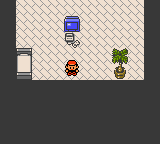

Context: The player has finished playing the SNES and is about to leave the room.
{'badges': {'badges': [], 'badges_byte': 0, 'count': 0}, 'events': {}, 'last_button': 'down', 'party': {'party_size': 0, 'pokemon': []}, 'position': {'map_id': 38, 'x': 3, 'y': 7}}


In [28]:
# Get the current screen
response = requests.get(f"{BASE_URL}/screen?format=base64")
screen_data = response.json()["image"]
screen_image = Image.open(BytesIO(base64.b64decode(screen_data)))

# Save the image in the specified directory with a filename that includes the current count
screen_image.save(f"Images/image_{count}.png")

# Get game state
game_state = requests.get(f"{BASE_URL}/state").json()

# Make a decision based on the state and screen
# ... AI logic here ...
res = strict_json('''Based on the image and game state, make a decision of what to do next.
If previous actions failed, try other alternatives.
The player can be in a dialogue, or can be exploring a 2D map.
Coordinates are given as (x, y), x being the left to right axis, y being the up to down axis
left moves in the negative x direction, e.g. (x, y) to (x-1, y)
right moves in the positive x direction, e.g. (x, y) to (x+1, y),
up moves in the negative y direction, e.g. (x, y) to (x, y-1)
down moves in the positive y direction, e.g. (x, y) to (x, y+1)
a is typically used for confirming actions, selecting options, and interacting with elements in the game
b is typically used to cancel actions, go back to the previous screen, or exit menus
start is used to open the main menu, allowing players to access options like the Pokémon menu, bag, items, and settings
select is used to register key items, allowing players to quickly access them during gameplay''',
f'''Game Image: <<Images/image_{count}.png>>
Game State: {game_state}
Existing Context: {context}
Past Conversation: {conversation[:-5]}''',
output_format = {"Current State": "Describe what is happening right now based on Game Image and Game State",
                 "Thoughts": "What to do next",
                 "Next Action": "type: Enum['up', 'down', 'left', 'right', 'a', 'b', 'start', 'select']",
                 "Updated Context": "Update Existing Context with what has been done"},
                  llm = llm)

next_move = res["Next Action"]

# Add in what happened in previous state in conversation history
context = res["Updated Context"]
del res["Updated Context"]
res["Game Image"] = f"<<Images/image_{count}.png>>"
conversation.append(str(res))
                  
# Increment count by 1 for the next image
count += 1

# # Execute an action
requests.post(f"{BASE_URL}/button", json={"button": next_move})

print(res)
display(screen_image)
print("Context:", context)
print(game_state)